In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import sqlite3
from scipy.stats import norm
import pickle
import os

database_name = 'database_predict_inflation.db'
con = sqlite3.connect(os.path.join('Results', database_name))
cur = con.cursor()

# Transformation = 'No Transform'
Transformation = 'Transform'
# Target = 'Inflation'
Target = 'Inflation MoM'
Window_size = 534
Validation_size = 113
seed_list = [42, 43, 44, 45, 46]
# seed_list = [42]

In [2]:
forcast_start = pd.to_datetime('2015-01-01')
# Models = ['Random Walk','AR1', 'AR12','AR','Random Forest','XGBoost','XGBoost-subsample','Ridge','LASSO','ADALASSO','PCR','RKHS','NN']
Models = ['Random Walk','AR1', 'AR12','AR','AR1_12','RA','Random Forest','XGBoost','XGBoost-subsample','Ridge','LASSO','ADALASSO','PCR','RKHS','NN']
RMSE = {}
rolling_RMSE = {}
for seed in seed_list:
    for i, model in enumerate(Models):
        query = """SELECT * FROM RESULTS WHERE model='%s' and seed=%i and Transformation='%s' and Target='%s'""" %(model,seed,Transformation,Target)
        RESULTS = pd.read_sql(query, con)
        date_idx = forcast_start<=pd.to_datetime(RESULTS.Date)
        forecast_date = RESULTS.Date[date_idx]
        n_test = np.sum(date_idx)
        test_err = RESULTS.loc[date_idx,:].Value - RESULTS.loc[date_idx,:].Prediction
        RMSE[model,seed] = np.sqrt(np.mean((test_err)**2))
        rolling_RMSE[model,seed] = np.zeros((n_test-24,))
        for j in range(n_test-24):
            rolling_RMSE[model,seed][j] = np.sqrt(np.sum(test_err[j:j+24]**2)/24)


In [3]:
RMSE_pd = pd.Series(RMSE).reset_index()
RMSE_pd.columns = ['Model','seed','values']
RESULTS = RMSE_pd.pivot(index=['seed'], columns='Model', values='values')
seed_depend = ['Random Forest', 'XGBoost-subsample', 'NN']
seed_nodepend = ['Random Walk','AR1','AR12','AR1_12','AR','RA','Ridge','LASSO','ADALASSO', 'PCR', 'RKHS', 'XGBoost']
temp = RESULTS.index.astype(str)
RESULTS.index = 'seed='+temp 
with pd.option_context('display.precision', 5):
    display(RESULTS[seed_depend])
    display(RESULTS[seed_nodepend])


Model,Random Forest,XGBoost-subsample,NN
seed,,,
seed=42,0.00225,0.00225,3.86727
seed=43,0.00222,0.00224,2.80539
seed=44,0.00226,0.00226,2.87339
seed=45,0.00231,0.00223,2.78010
seed=46,0.00223,0.00228,3.89765


Model,Random Walk,AR1,AR12,AR1_12,AR,RA,Ridge,LASSO,ADALASSO,PCR,RKHS,XGBoost
seed,,,,,,,,,,,,
seed=42,0.00275,0.00246,0.00245,0.00247,0.00246,0.00289,0.00229,0.00225,0.00307,0.00233,0.00346,0.00228
seed=43,0.00275,0.00246,0.00245,0.00247,0.00246,0.00289,0.00229,0.00225,0.00307,0.00233,0.00346,0.00228
seed=44,0.00275,0.00246,0.00245,0.00247,0.00246,0.00289,0.00229,0.00225,0.00307,0.00233,0.00346,0.00228
seed=45,0.00275,0.00246,0.00245,0.00247,0.00246,0.00289,0.00229,0.00225,0.00307,0.00233,0.00346,0.00228
seed=46,0.00275,0.00246,0.00245,0.00247,0.00246,0.00289,0.00229,0.00225,0.00307,0.00233,0.00346,0.00228


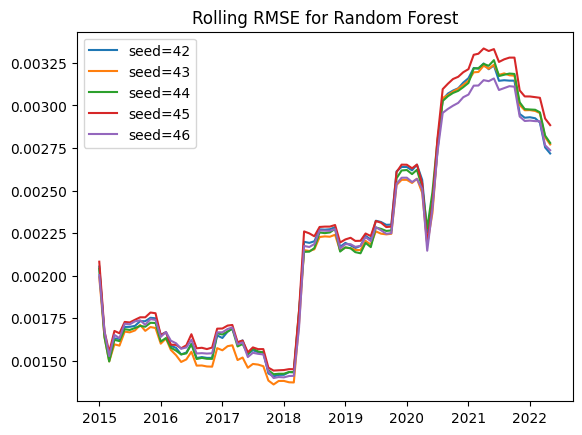

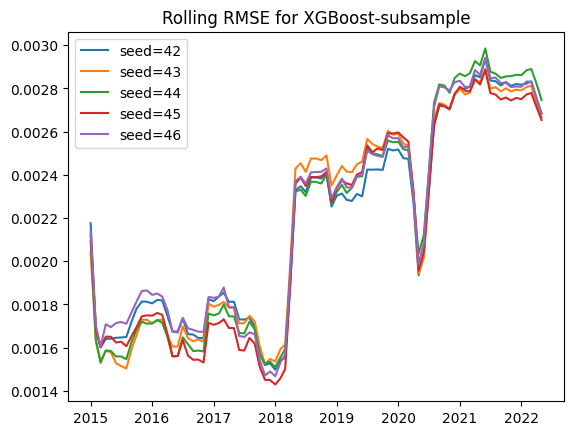

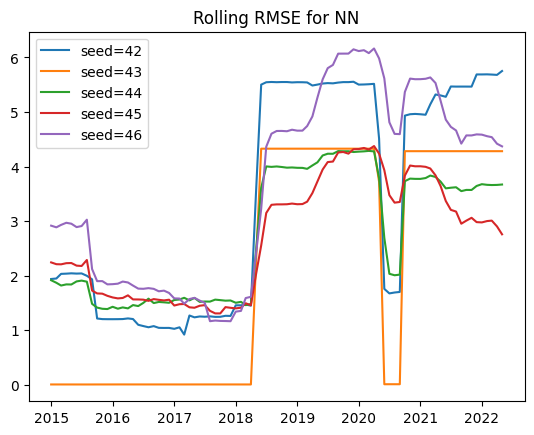

In [4]:
rolling_RMSE_pd = pd.Series(rolling_RMSE).reset_index()
rolling_RMSE_pd.columns = ['Model','seed','values']

for sd_md in seed_depend:
    plt.plot(pd.to_datetime(forecast_date[:-24]),np.vstack(rolling_RMSE_pd.query("Model=='%s'"%sd_md)['values']).T)
    plt.title('Rolling RMSE for %s'%sd_md)
    plt.legend(['seed=%i'%sd for sd in seed_list])
    plt.show()


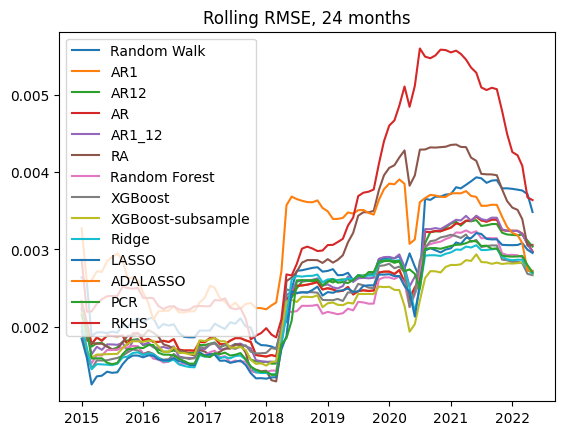

In [5]:
seed = 42
query_rst = rolling_RMSE_pd.query("seed==%i and Model!='NN'"%seed)

plt.plot(pd.to_datetime(forecast_date[:-24]),np.vstack(query_rst['values']).T)
plt.legend(query_rst['Model'])
plt.title('Rolling RMSE, 24 months')
plt.show()

In [6]:
file_name ='Validation_Err_MoM_%s.pkl'%(Transformation.replace(' ','_'))
with open(os.path.join('Results', file_name), 'rb') as inp:
    Validation_Err_read = pickle.load(inp)

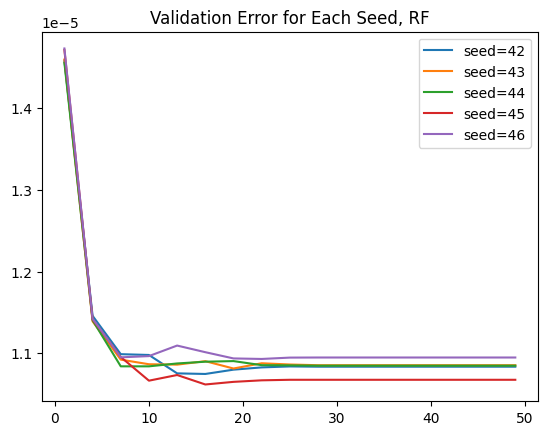

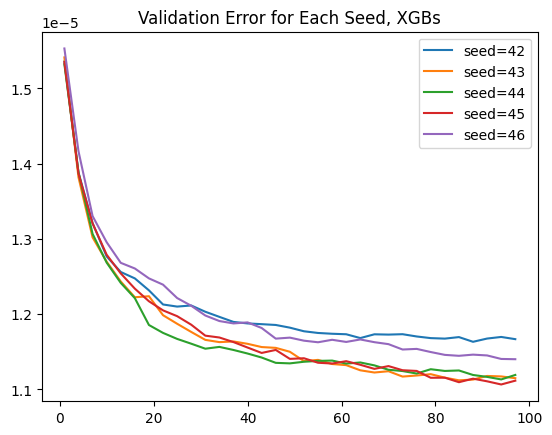

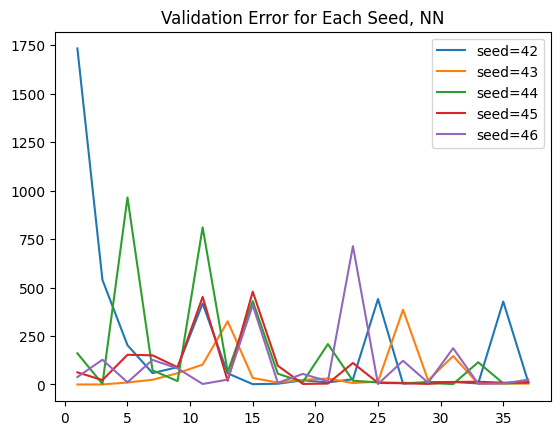

In [7]:
seed_depend = ["RF","XGBs","NN"]
# Validation_Err_read_pd
# # Validation_Err_read
Validation_Err_read_pd = pd.Series(Validation_Err_read).reset_index()
Validation_Err_read_pd.columns = ['Model','seed','dataframe']
for sd_md in seed_depend:
    query = Validation_Err_read_pd.query("Model=='%s'"%sd_md)['dataframe']
    for i in range(len(seed_list)):
        val = query.iloc[i].val_err
        param = query.iloc[i].iloc[:,0]
        plt.plot(param,val)
    plt.legend(['seed=%i'%sd for sd in seed_list])
    plt.title('Validation Error for Each Seed, %s'%sd_md)
    plt.show()

Partially Linear Models

In [12]:
num_lags = 1
Target

'Inflation MoM'

In [13]:
forcast_start = pd.to_datetime('2015-01-01')
Models = ['Random Forest','XGBoost','XGBoost-subsample','PCR','PCRp','RKHS','NN']
Models = [nm+'-PL-%ilags'%num_lags for nm in Models]
Models = np.append(Models,'AR')
RMSE = {}
rolling_RMSE = {}
for seed in seed_list:
    for i, model in enumerate(Models):
        query = """SELECT * FROM RESULTS WHERE model='%s' and seed=%i and Transformation='%s' and Target='%s'""" %(model,seed,Transformation,Target)
        RESULTS = pd.read_sql(query, con)
        date_idx = forcast_start<=pd.to_datetime(RESULTS.Date)
        forecast_date = RESULTS.Date[date_idx]
        n_test = np.sum(date_idx)
        test_err = RESULTS.loc[date_idx,:].Value - RESULTS.loc[date_idx,:].Prediction
        RMSE[model,seed] = np.sqrt(np.mean((test_err)**2))
        rolling_RMSE[model,seed] = np.zeros((n_test-24,))
        for j in range(n_test-24):
            rolling_RMSE[model,seed][j] = np.sqrt(np.sum(test_err[j:j+24]**2)/24)


In [15]:
RMSE_pd = pd.Series(RMSE).reset_index()
RMSE_pd.columns = ['Model','seed','values']
RMSE_pd
RESULTS = RMSE_pd.pivot(index=['seed'], columns='Model', values='values')
seed_depend = ['Random Forest-PL-1lags', 'XGBoost-subsample-PL-1lags', 'NN-PL-1lags']
seed_nodepend = ['AR','PCR-PL-1lags','PCRp-PL-1lags', 'RKHS-PL-1lags', 'XGBoost-PL-1lags']
temp = RESULTS.index.astype(str)
RESULTS.index = 'seed='+temp 
with pd.option_context('display.precision', 5):
    display(RESULTS[seed_depend])
    display(RESULTS[seed_nodepend])

Model,Random Forest-PL-1lags,XGBoost-subsample-PL-1lags,NN-PL-1lags
seed,,,
seed=42,0.00227,0.00236,1.74211
seed=43,0.00228,0.00233,2.82406
seed=44,0.00251,0.00234,2.02930
seed=45,0.00249,0.00236,0.87046
seed=46,0.00249,0.00236,2.21092


Model,AR,PCR-PL-1lags,PCRp-PL-1lags,RKHS-PL-1lags,XGBoost-PL-1lags
seed,,,,,
seed=42,0.00246,0.00257,0.00239,0.00236,0.00241
seed=43,0.00246,0.00257,0.00239,0.00236,0.00241
seed=44,0.00246,0.00257,0.00239,0.00236,0.00241
seed=45,0.00246,0.00257,0.00239,0.00236,0.00241
seed=46,0.00246,0.00257,0.00239,0.00236,0.00241


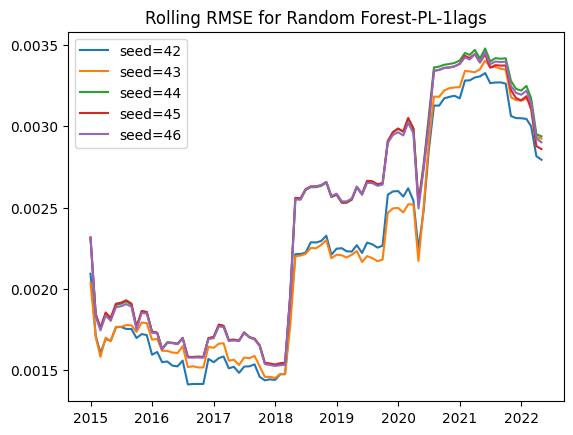

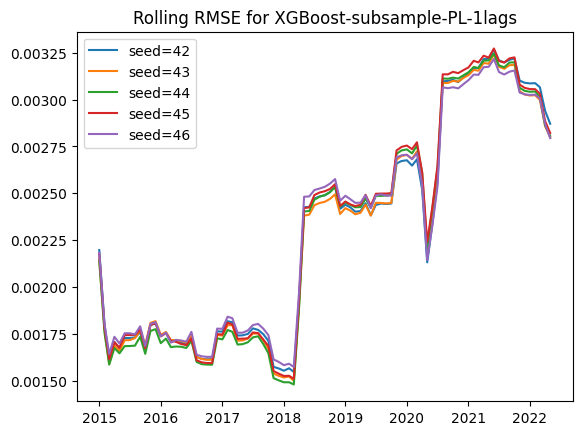

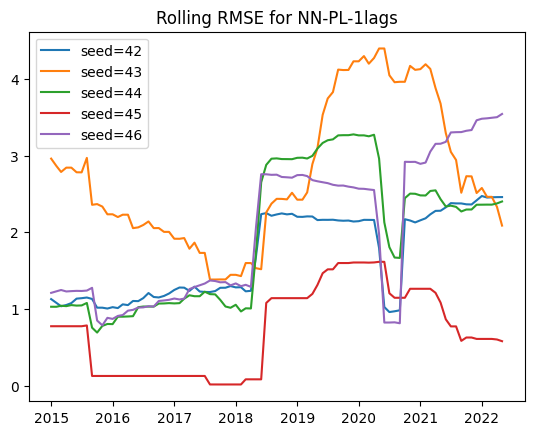

In [16]:
rolling_RMSE_pd = pd.Series(rolling_RMSE).reset_index()
rolling_RMSE_pd.columns = ['Model','seed','values']

for sd_md in seed_depend:
    plt.plot(pd.to_datetime(forecast_date[:-24]),np.vstack(rolling_RMSE_pd.query("Model=='%s'"%sd_md)['values']).T)
    plt.title('Rolling RMSE for %s'%sd_md)
    plt.legend(['seed=%i'%sd for sd in seed_list])
    plt.show()

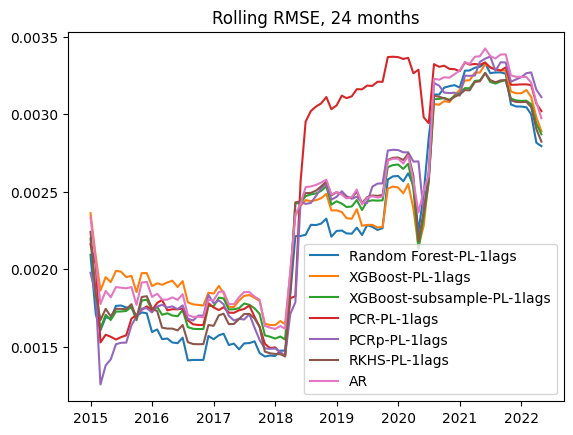

In [18]:
seed = 42
query_rst = rolling_RMSE_pd.query("seed==%i and Model!='NN-PL-1lags'"%seed)

plt.plot(pd.to_datetime(forecast_date[:-24]),np.vstack(query_rst['values']).T)
plt.legend(query_rst['Model'])
plt.title('Rolling RMSE, 24 months')
plt.show()

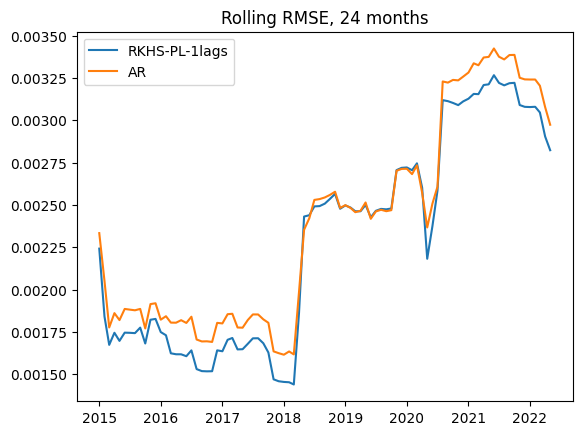

In [21]:
seed = 42
query_rst = rolling_RMSE_pd.query("seed==%i and Model!='NN-PL-1lags'"%seed)
query_rst = query_rst.loc[np.isin(query_rst.Model, ['RKHS-PL-1lags','AR'])]
plt.plot(pd.to_datetime(forecast_date[:-24]),np.vstack(query_rst['values']).T)
plt.legend(query_rst['Model'])
plt.title('Rolling RMSE, 24 months')
plt.show()

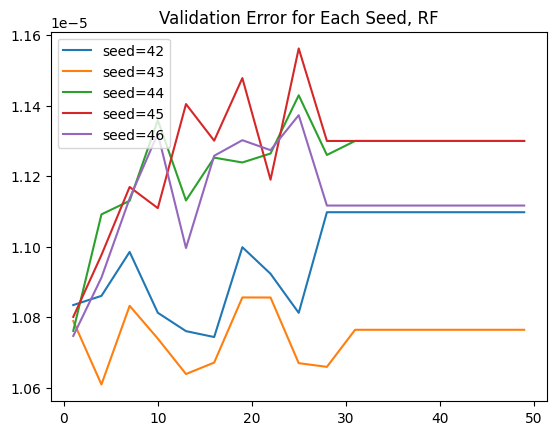

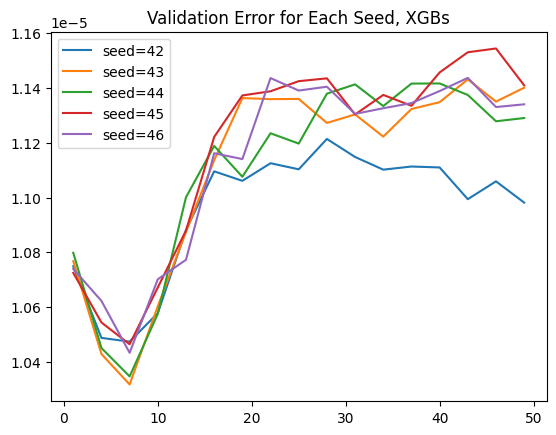

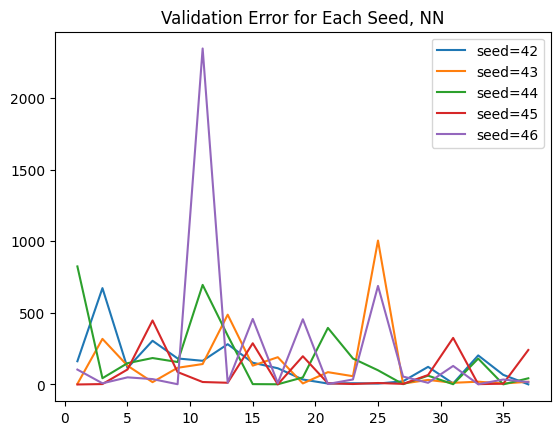

In [23]:
file_name ='Validation_Err_MoM_PL_1lags_%s.pkl'%(Transformation.replace(' ','_'))
with open(os.path.join('Results', file_name), 'rb') as inp:
    Validation_Err_read = pickle.load(inp)

seed_depend = ["RF","XGBs","NN"]
# Validation_Err_read_pd
# # Validation_Err_read
Validation_Err_read_pd = pd.Series(Validation_Err_read).reset_index()
Validation_Err_read_pd.columns = ['Model','seed','dataframe']
for sd_md in seed_depend:
    query = Validation_Err_read_pd.query("Model=='%s'"%sd_md)['dataframe']
    for i in range(len(seed_list)):
        val = query.iloc[i].val_err
        param = query.iloc[i].iloc[:,0]
        plt.plot(param,val)
    plt.legend(['seed=%i'%sd for sd in seed_list])
    plt.title('Validation Error for Each Seed, %s'%sd_md)
    plt.show()

In [24]:
with open(os.path.join('Results', 'beta_tot_PL_2lags_%s.pkl'%(Transformation.replace(' ','_'))), 'rb') as inp:
    beta_tot_read = pickle.load(inp)

beta_tot_read_pd = pd.Series(beta_tot_read).reset_index()
beta_tot_read_pd.columns = ['Model','seed','beta']
beta_tot_read_pd.pivot(index='seed', columns='Model', values='beta')

# seed_depend = ['RF', 'XGBs', 'NN']
# seed_nodepend = ['LASSO', 'Ridge', 'PCR', 'XGB']
# with pd.option_context('display.precision', 5):
    # display(beta_tot_read_pd.pivot(index='seed',columns='Model',values='beta'))
#     display(temp[seed_depend])
#     display(temp[seed_nodepend])

Model,NN,PCR,PCRp,RF,RKHS,XGB,XGBs
seed,,,,,,,
42,"[0.5652748610989089, 0.5625160189604823]","[1.3160667869771117, -0.3090028706591656]","[1.2446671235038027, -0.18623186469856812]","[1.1837618035893898, -0.27855830942902127]","[0.0004123571222328067, 1.3159251441681352, -0...","[1.1433346951971473, -0.16679396565410443]","[1.3136559552031315, -0.33278086238892257]"
43,"[1.379691768417473, -0.4411548875523721]","[1.3160667869771117, -0.3090028706591656]","[1.2446671235038027, -0.18623186469856812]","[1.1981337210754843, -0.27757318826144767]","[0.0004123571222328067, 1.3159251441681352, -0...","[1.1433346951971473, -0.16679396565410443]","[1.309826188008671, -0.31299754827767146]"
44,"[-0.47794272650512104, -0.15966807356198132]","[1.3160667869771117, -0.3090028706591656]","[1.2446671235038027, -0.18623186469856812]","[1.1942540936633614, -0.27809545102511724]","[0.0004123571222328067, 1.3159251441681352, -0...","[1.1433346951971473, -0.16679396565410443]","[1.2930618165810017, -0.3080235089952623]"
45,"[1.1181517755677364, 1.5944412590043202]","[1.3160667869771117, -0.3090028706591656]","[1.2446671235038027, -0.18623186469856812]","[1.2067191143092157, -0.28783933418170327]","[0.0004123571222328067, 1.3159251441681352, -0...","[1.1433346951971473, -0.16679396565410443]","[1.2715597461085366, -0.2813436852142459]"
46,"[-0.016849155487457412, 0.37191066888224544]","[1.3160667869771117, -0.3090028706591656]","[1.2446671235038027, -0.18623186469856812]","[1.190491474335921, -0.27227507650698085]","[0.0004123571222328067, 1.3159251441681352, -0...","[1.1433346951971473, -0.16679396565410443]","[1.2848310179336622, -0.2947822498661168]"
